In [5]:
import csv
import umap
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict
import pyvis
from pyvis.network import Network
import numpy as np
import seaborn as sns
import branca.colormap as cm
import branca
import pandas as pd
import re
from textwrap import wrap
import json




In [9]:
project_path = "/Users/pardan/Code/connect/"

In [10]:
# Read attendees and their responses from a CSV file, replace attendees.csv with own link or file name
attendees_map = {}
with open(project_path+ 'responses.csv', newline='') as csvfile:
    attendees = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(attendees)  # Skip the header row
    for row in attendees:
        name, paragraph = row
        attendees_map[paragraph] = name

# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)

# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [11]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
reducer = umap.UMAP()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)

/Users/pardan/Code/connect/connectenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/pardan/Code/connect/connectenv/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


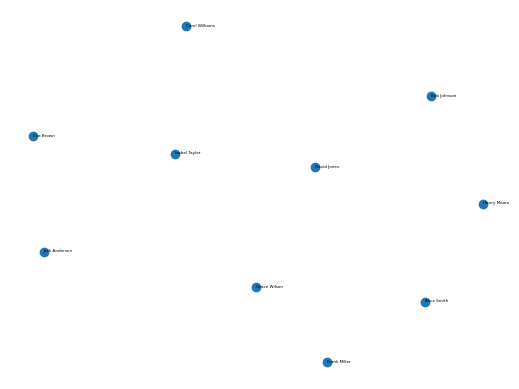

In [12]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="3")

# Clean-up and Export
plt.axis('off')
plt.savefig(project_path+'a_visualization.png', dpi=800)

In [14]:
from collections import defaultdict
import json
import pandas as pd
from scipy import spatial

# Providing top matches
top_matches = {}
all_personal_pairs = defaultdict(list)

for person in attendees_map.values():
    for person1 in attendees_map.values():
        # compute and cast to native Python float
        dist = float(spatial.distance.cosine(
            person_embeddings[person1],
            person_embeddings[person]
        ))
        all_personal_pairs[person].append([dist, person1])

n = 5
data_day_list = []

for person in attendees_map.values():
    # sort by distance, skip self at index 0, take next n entries
    matches = sorted(all_personal_pairs[person], key=lambda x: x[0])[1 : n+1]
    top_matches[person] = matches

    mini_df = pd.DataFrame(matches, columns=['Weight', 'Target'])
    mini_df['Source'] = person
    data_day_list.append(mini_df)

# Convert everything in top_matches to native Python types (if needed)
top_matches_py = {
    person: [[float(w), tgt] for w, tgt in matches]
    for person, matches in top_matches.items()
}

# Output this information as JSON
with open(project_path + 'b_top5_matches.json', 'w') as json_file:
    json.dump(top_matches_py, json_file, indent=2)

# Output this information as CSV
df = pd.concat(data_day_list, ignore_index=True)
df.to_csv(project_path + 'b_top5_matches.csv', index=False)


In [15]:
# Get the colour pallette
colour = sns.color_palette("pastel",len(x)).as_hex()

# Add colour pallette to the df
df1 = pd.DataFrame([label,colour])
df1 = df1.T
df1.rename(columns={0: 'Source', 1: 'Colour'},inplace=True)
df = df.set_index('Source').join(df1.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)

# Add colour pallette for both the df Target and Source:
df1.rename(columns={'Source': 'Target'},inplace=True)
df = df.set_index('Target').join(df1.set_index('Target'),lsuffix='_Source', rsuffix='_Target')
df['Target'] = df.index
df = df.reset_index(drop=True)
print(df)

# Add paragraphs to the df
df2 = pd.DataFrame([label,paragraphs])
df2 = df2.T
df2.rename(columns={0: 'Source', 1: 'Paragraphs'},inplace=True)
df = df.set_index('Source').join(df2.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)
print(df)

# Create a cleaned Dataframe of just the Source and and Paragraph information
df_new = df[["Source","Paragraphs"]]
df_new = df_new.drop_duplicates()
df_new.set_index('Source', inplace=True)
     

      Weight Colour_Source          Source Colour_Target          Target
0   0.426868       #a1c9f4     Alice Smith       #cfcfcf     Henry Moore
1   0.451659       #a1c9f4     Alice Smith       #debb9b    Frank Miller
2   0.599299       #a1c9f4     Alice Smith       #ffb482     Bob Johnson
3   0.619613       #a1c9f4     Alice Smith       #fab0e4    Grace Wilson
4   0.633456       #a1c9f4     Alice Smith       #8de5a1  Carol Williams
5   0.528049       #ffb482     Bob Johnson       #cfcfcf     Henry Moore
6   0.599299       #ffb482     Bob Johnson       #a1c9f4     Alice Smith
7   0.605189       #ffb482     Bob Johnson       #ff9f9b     David Jones
8   0.646103       #ffb482     Bob Johnson       #debb9b    Frank Miller
9   0.721622       #ffb482     Bob Johnson       #fab0e4    Grace Wilson
10  0.633456       #8de5a1  Carol Williams       #a1c9f4     Alice Smith
11  0.665561       #8de5a1  Carol Williams       #b9f2f0   Jack Anderson
12  0.683764       #8de5a1  Carol Williams       #d

In [16]:
# Intitalize bucket size and colour palettes
buckets = [100] * len(x)
colour = sns.color_palette("pastel",len(x)).as_hex()

# Initialize network
g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add unconnected nodes to the network
g.add_nodes(list(range(1,len(x)+1)), value=buckets,
                         title=paragraphs,
                         x=np.array(x).astype(np.float64),
                         y=np.array(y).astype(np.float64),
                         label=label,
                         color=colour)

# Output the visualization
g.toggle_physics(True)
g.show(project_path+'c_simple_viz.html', notebook=False)
     

/Users/pardan/Code/connect/c_simple_viz.html


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
